In [9]:
using Plots; pyplot();
using DelimitedFiles;
using AugmentedGaussianProcesses;

In [10]:
X = readdlm("data/banana_X_train");
Y = readdlm("data/banana_Y_train")[:];

In [11]:
# Run sparse classification with increasing number of inducing points
models = []
Ms = [4, 8, 16, 32, 64]
kernel = RBFKernel(1.0)
for (index, num_inducing) in enumerate(Ms)
    m = SparseBSVM(X, Y, kernel=kernel,
        OptimizeIndPoints=true,Stochastic=false,Autotuning=true,m=num_inducing)
    println("Training with $(num_inducing) points")
    @time m.train(iterations=20)
    push!(models,m);
end

Training with 4 points
  0.053390 seconds (112.34 k allocations: 131.856 MiB, 31.25% gc time)
Training with 8 points
  0.109966 seconds (115.36 k allocations: 367.671 MiB, 15.49% gc time)
Training with 16 points
  0.350014 seconds (121.43 k allocations: 1.186 GiB, 15.47% gc time)
Training with 32 points
  1.422290 seconds (133.56 k allocations: 4.309 GiB, 13.44% gc time)
Training with 64 points
  7.369735 seconds (163.49 k allocations: 16.496 GiB, 34.31% gc time)


In [12]:
mfull = BatchBSVM(X, Y, kernel=kernel,Autotuning=true)
println("Training with full model")
@time mfull.train(iterations=5);
push!(models,mfull);

Training with full model
 43.690888 seconds (42.88 k allocations: 9.860 GiB, 4.45% gc time)


In [13]:
function compute_Grid(model,nGrid=50)
    mins = [-3.25,-2.85]
    maxs = [3.65,3.4]
    xlin = range(mins[1],stop=maxs[1],length=nGrid)
    ylin = range(mins[2],stop=maxs[2],length=nGrid)
    Xplot = hcat([j for i in xlin, j in ylin][:],[i for i in xlin, j in ylin][:])
    y = model.predictproba(Xplot)
    return (y,xlin,ylin)
    end;

In [14]:
function plotdata(X,Y)
    plot(X[Y.==1,1],X[Y.==1,2],t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="",size=(300,500));
    plot!(X[Y.==-1,1],X[Y.==-1,2],t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="")
    end;

In [15]:
function plotcontour(model,X,Y)
    nGrid = 30
    (predic,x,y) = compute_Grid(model,nGrid);
    plotdata(X,Y)
    if in(:m,fieldnames(typeof(model)))
        plot!(model.inducingPoints[:,1],model.inducingPoints[:,2],msize=2.0,color="black",t=:scatter,lab="")
    end
    return plot!(x,y,reshape(predic,nGrid,nGrid),cbar=false,t=:contour,levels=[0.5],fill=false,fillalpha=0.2,title=(in(:m,fieldnames(typeof(model))) ? "M = $(model.m)" : "full"))
end;

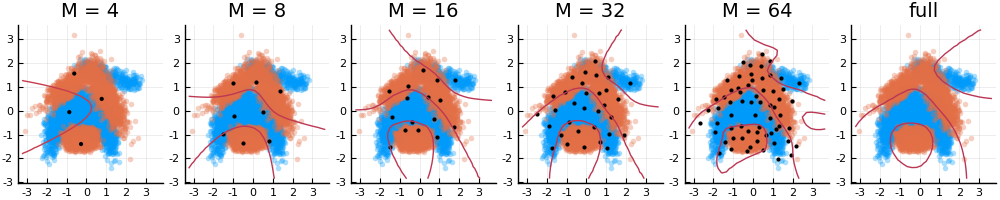

In [16]:
plot(broadcast(x->plotcontour(x,X,Y),models)...,layout=(1,length(models)),size=(1000,200))